# STAT5243 Project 4: Causal Inference

**Group 2:**

    Wendy Doan
    Yibai Liu
    Yiwen Fang
    Shuqi Yu
    Zhihang Xia

***(To all) Things to do:***

    1) try other boosting methods (e.g. adaboost) for propensity score estimation
    2) time the models
    3) finish regression adjustment
    4) try reweighting & resampling  :  done

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from collections import Counter
import warnings
warnings.filterwarnings('ignore')


# Set a random seed for reproduction.
RANDOM_STATE = np.random.seed(2021)

# train-test split for propensity score
from sklearn.model_selection import train_test_split
# grid search
from sklearn.model_selection import GridSearchCV
# propensity score from tree models
#import xgboost as xgb
#from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
# Stratification and Regression Adjustment
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LinearRegression

#from imblearn.over_sampling import RandomOverSampler
#from imblearn.combine import SMOTETomek
#from imblearn.under_sampling import RandomUnderSampler
#from imblearn.under_sampling import NearMiss

In [3]:
# baseline propensity score
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV


## Intro

## Exploring the data

In [8]:
highDim_dataset = pd.read_csv('../data/highDim_dataset.csv')
lowDim_dataset = pd.read_csv('../data/lowDim_dataset.csv')


In [9]:
high_true_ATE = -54.8558
low_true_ATE = 2.0901

In [10]:
highDim_dataset.shape

(2000, 187)

In [11]:
highDim_dataset.head()

,Y,A,V1,V2,V3,V4,V5,V6,V7,V8,...,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185
0,41.224513,0,0,1,4,18,17,-1,1,0.75,...,8,10,8,9,8,-1,-1,-1,-1,-1
1,40.513875,0,0,0,1,10,6,-1,10,0.35,...,6,5,6,8,5,-1,-1,-1,-1,-1
2,38.495476,0,0,0,16,8,4,4,4,0.40,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
3,33.001889,0,1,0,3,10,2,-1,5,0.41,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
4,37.043603,0,1,1,11,21,10,10,20,0.43,...,6,8,7,7,7,6,7,6,6,7


In [12]:
lowDim_dataset.shape

(500, 24)

In [13]:
lowDim_dataset.head()

,Y,A,V1,V2,V3,V4,V5,V6,V7,V8,...,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22
0,30.486999,0,0.00,0.00,0.00,0.0,0.0,0.00,0.0,0.00,...,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.00,9.09,1.149622
1,18.208417,0,0.00,0.00,0.00,0.0,0.0,0.00,0.0,1.40,...,0.7,0.00,1.40,0.0,1.40,0.0,0.00,0.00,0.00,2.887702
2,13.485040,0,0.00,0.00,0.00,0.0,0.0,0.00,0.0,0.00,...,0.0,0.00,3.57,0.0,0.00,0.0,0.00,0.00,0.00,0.000000
3,25.699678,1,2.38,0.00,0.00,0.0,0.0,0.00,0.0,0.00,...,0.0,0.00,2.38,0.0,2.38,0.0,0.00,0.00,0.00,0.405465
4,23.752968,0,0.15,0.15,0.05,0.1,0.0,0.42,0.1,0.95,...,0.0,0.36,3.16,0.0,1.58,0.0,0.52,0.31,0.00,1.574639


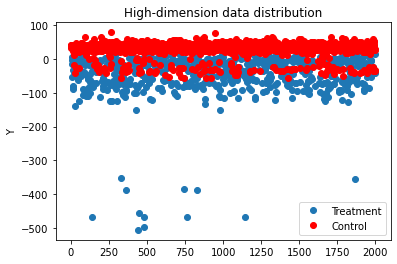

In [14]:
plt.plot(highDim_dataset[highDim_dataset.A == 1].Y, 'o', label="Treatment")
plt.plot(highDim_dataset[highDim_dataset.A == 0].Y, 'ro', label="Control")
plt.title("High-dimension data distribution")
plt.ylabel("Y")
plt.legend()
plt.show()

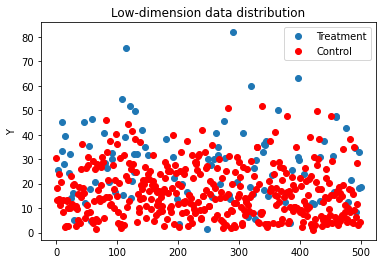

In [15]:
plt.plot(lowDim_dataset[lowDim_dataset.A == 1].Y, 'o', label='Treatment')
plt.plot(lowDim_dataset[lowDim_dataset.A == 0].Y, 'ro', label = 'Control')
plt.title("Low-dimension data distribution")
plt.ylabel("Y")
plt.legend()
plt.show()

#### Naive estimate of ATE

In [16]:
def naive_ATE(dataset):
    return np.average(dataset[dataset.A == 1].Y) - np.average(dataset[dataset.A == 0].Y)

In [17]:
# High-dimention
naive_ATE(highDim_dataset)

-75.17133436876799

In [18]:
# Low-dimention
naive_ATE(lowDim_dataset)

10.602068661915688

### Are the data sets balanced? 

In [19]:
print("High-dimention\nTreatment:", len(highDim_dataset[highDim_dataset.A == 1]), "\nControl:", len(highDim_dataset[highDim_dataset.A == 0]))

High-dimention
Treatment: 643 
Control: 1357


In [20]:
print("Low-dimention\nTreatment:", len(lowDim_dataset[lowDim_dataset.A == 1]), "\nControl:", len(lowDim_dataset[lowDim_dataset.A == 0]))

Low-dimention
Treatment: 106 
Control: 394


Slightly imbalanced, but acceptable.

## rebalance the data

###### first method: oversampling

In oversampling, we increase the number of samples in minority class to match up to the number of samples of the majority class.

In simple terms, you take the minority class and try to create new samples that could match up to the length of the majority samples.

In [21]:
ovs = RandomOverSampler(random_state = 42)
x,y = ovs.fit_resample(highDim_dataset.loc[:,highDim_dataset.columns != 'A'],highDim_dataset.A)
highDim_dataset_oversampling=x
highDim_dataset_oversampling["A"]=y
print("High-dimention_resample \nTreatment:", len(highDim_dataset_oversampling[highDim_dataset_oversampling.A == 1]),
      "\nControl:", len(highDim_dataset_oversampling[highDim_dataset_oversampling.A == 0]))

NameError: name 'RandomOverSampler' is not defined

In [22]:
highDim_dataset_oversampling.head()

NameError: name 'highDim_dataset_oversampling' is not defined

In [23]:
ovs = RandomOverSampler(random_state = 42)
x1,y1 = ovs.fit_resample(lowDim_dataset.loc[:, lowDim_dataset.columns != 'A'],lowDim_dataset.A)
lowDim_dataset_oversampling=x1
lowDim_dataset_oversampling["A"]=y1
print("High-dimention_resample \nTreatment:", len(lowDim_dataset_oversampling[lowDim_dataset_oversampling.A == 1]),
      "\nControl:", len(lowDim_dataset_oversampling[lowDim_dataset_oversampling.A == 0]))

NameError: name 'RandomOverSampler' is not defined

###### second method: SMOTETomek

Synthetic Minority Over-sampling Technique(SMOTE) is a technique that generates new observations by interposing between observations in the existing data.

In Simple terms, It is a technique used to generate new data points for the minority classes based on existing data. 

In [24]:
smk = SMOTETomek()
x_res,y_res = smk.fit_resample(highDim_dataset.loc[:,highDim_dataset.columns != 'A'],highDim_dataset.A)
highDim_dataset_smote=x_res
highDim_dataset_smote["A"]=y_res
print("High-dimention_SMOTE \nTreatment:", len(highDim_dataset_smote[highDim_dataset_smote.A == 1]),
      "\nControl:", len(highDim_dataset_smote[highDim_dataset_smote.A == 0]))

NameError: name 'SMOTETomek' is not defined

In [25]:
smk1 = SMOTETomek()
x_res1,y_res1 = smk1.fit_resample(lowDim_dataset.loc[:,lowDim_dataset.columns != 'A'],lowDim_dataset.A)
lowDim_dataset_smote=x_res1
lowDim_dataset_smote["A"]=y_res1
print("LOW-dimention_SMOTE \nTreatment:", len(lowDim_dataset_smote[lowDim_dataset_smote.A == 1]),
      "\nControl:", len(lowDim_dataset_smote[lowDim_dataset_smote.A == 0]))

NameError: name 'SMOTETomek' is not defined

## Split into train and test set 80:20

In [26]:
def split_train_test(dataset):
    X = np.array(dataset.iloc[:, 1:-2])
    y = np.array(dataset.Y)
    A = np.array(dataset.A)
    
    idx_train, idx_test, y_train, y_test = train_test_split(range(X.shape[0]), y, test_size=0.2, random_state=RANDOM_STATE)
    X_train = X[idx_train]
    X_test = X[idx_test]
    A_train = A[idx_train]
    A_test = A[idx_test]
    return X_train, X_test, y_train, y_test, A_train, A_test

# Split arrays into train and test set
X_high_train, X_high_test, y_high_train, y_high_test, A_high_train, A_high_test= split_train_test(highDim_dataset_oversampling)
X_low_train, X_low_test, y_low_train, y_low_test, A_low_train, A_low_test= split_train_test(lowDim_dataset_oversampling)

NameError: name 'highDim_dataset_oversampling' is not defined

## Propensity Score - Logistic Regression (not needed?)

High dimensional data baseline

In [27]:
logisticRegr_high = LogisticRegression(max_iter=10000)

In [28]:
logisticRegr_high.fit(X_high_train, z_high_train)

NameError: name 'X_high_train' is not defined

In [29]:
logisticRegr_high.score(X_high_train, z_high_train)

NameError: name 'X_high_train' is not defined

In [30]:
logisticRegr_high.score(X_high_test, z_high_test)

NameError: name 'X_high_test' is not defined

Low dimensional data baseline

In [ ]:
logisticRegr_low = LogisticRegression()

In [ ]:
logisticRegr_low.fit(X_low_train, z_low_train)

In [ ]:
logisticRegr_low.score(X_low_train, z_low_train)

In [ ]:
logisticRegr_low.score(X_low_test, z_low_test)

## Propensity Score - Boosted Stumps

#### Gradient Boosting

In [ ]:
param_grid = {
              'learning_rate': [0.1,0.05,0.01],
              'max_depth': [2,3,5],
              'min_samples_split': [2, 4],
              'n_estimators': [100,150],
              'min_samples_leaf':[1,3,5]
              }

In [ ]:
def grid_search(X:np.array, A:np.array, model, param_grid=param_grid, cv=10, print_step = True, sample_weight=None):
    """
    Takes a baseline model and does grid search among parameters in the param_grid with cross validation.
    Returns the model with best hyparameters after searching
    
    Inputs:
    -------
    X: np.array, feature set for fitting the model
    y: np.array, target for predictions
    model: an sklearn estimator object
    param_grid: dict, a dictionary that contains possible search values for parameters
    print_step: bool, whether to print detailed scores for each combination of parameters;
                set print_step=False to only report the best combination of parameters and the best scores
    sample_weight:np.array, instance weights, optional
    
    
    Output:
    -------
    The sklearn estimator object with hyperparameters set to be the best parameters from search 
    """
    if sample_weight is None:
        clf = GridSearchCV(model, param_grid, cv=cv, n_jobs=-1).fit(X, A)
    else:
        clf = GridSearchCV(model, param_grid, cv=cv, n_jobs=-1).fit(X, A, sample_weight = sample_weight)
    print("Best accuracy: %0.3f" % (clf.best_score_))
    print()
    print("Best parameters: %r" % clf.best_params_)
    print('-'*30)
    if print_step:
        means = clf.cv_results_['mean_test_score']
        stds = clf.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        		print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
        print('-'*30)

    return(model.set_params(**clf.best_params_))

In [ ]:
gbm_high = grid_search(X_high_train, A_high_train, model=GradientBoostingClassifier(random_state=RANDOM_STATE))
gbm_low = grid_search(X_low_train, A_low_train, model=GradientBoostingClassifier(random_state=RANDOM_STATE))

In [ ]:
# A copy of best hyperparameters from grid search
# Can skip the last cell because grid search takes minutes
best_params_high = {'learning_rate': 0.05, 'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 4, 'n_estimators': 100}
best_params_low = {'learning_rate': 0.05, 'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 4, 'n_estimators': 100}

gbm_high = GradientBoostingClassifier(random_state=RANDOM_STATE).set_params(**best_params_high)
gbm_low = GradientBoostingClassifier(random_state=RANDOM_STATE).set_params(**best_params_low)

In [ ]:
# Fit the models
gbm_high = gbm_high.fit(X_high_train, A_high_train)
gbm_low = gbm_low.fit(X_low_train, A_low_train)

# Predict the propensity scores
ps_high_train = gbm_high.predict_proba(X_high_train)[:, 1]
ps_low_train = gbm_low.predict_proba(X_low_train)[:, 1]

In [ ]:
gbm_high.score(X_high_train, A_high_train)

In [ ]:
gbm_low.score(X_low_train, A_low_train)

#### XG Boost (weighted)

In [ ]:
param_grid_xgb = {
    'objective':['binary:logistic', 'reg:squarederror'],
    'n_estimators':[10,50,100],
    'min_child_weight': [1, 5, 10],
    'gamma': [0.5, 1.0, 1.5],
    'subsample': [0.3, 0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8],
    'max_depth': [3, 4]#,
    #'scale_pos_weight':[1, 2, 4]
}

In [ ]:
# Caution: This chunk is sloooooooooow, so maybe you wanna skip this cell and instead use the next 
# cell which gives the same results
xgb_high = grid_search(X_high_train, A_high_train, param_grid = param_grid_xgb, print_step=False, cv=5,
                       model=XGBClassifier(n_jobs=-1,random_state=RANDOM_STATE))
xgb_low = grid_search(X_low_train, A_low_train, param_grid = param_grid_xgb, print_step=False,cv=5,
                      model=XGBClassifier(n_jobs=-1,random_state=RANDOM_STATE))

In [ ]:
# A copy of best hyperparameters from grid search
# Can skip the last cell because grid search takes minutes
best_params_xgb_high = {'colsample_bytree': 0.8, 'gamma': 1.0, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 10, 
                        'objective': 'reg:squarederror', 'subsample': 0.8}
best_params_xgb_low = {'colsample_bytree': 0.6, 'gamma': 1.0, 'max_depth': 3, 'min_child_weight': 10, 'n_estimators': 50, 
                       'objective': 'binary:logistic', 'subsample': 0.8}

xgb_high = XGBClassifier(n_jobs=-1,random_state=RANDOM_STATE).set_params(**best_params_xgb_high)
xgb_low = XGBClassifier(n_jobs=-1,random_state=RANDOM_STATE).set_params(**best_params_xgb_low)

In [ ]:
# Fit the models
xgb_high = xgb_high.fit(X_high_train, A_high_train)
xgb_low = xgb_low.fit(X_low_train, A_low_train)

# Predict the propensity scores
ps_high_train_xgb = xgb_high.predict_proba(X_high_train)[:, 1]
ps_low_train_xgb = xgb_low.predict_proba(X_low_train)[:, 1]

In [ ]:
xgb_high.score(X_high_train, A_high_train)

In [ ]:
xgb_low.score(X_low_train, A_low_train)

XGBoost with sample weights

In [ ]:
#sample_weight_high = np.array([Counter(A_high_train)[0], Counter(A_high_train)[1]])
#print(sample_weight_high)

#sample_weight_low = np.array([Counter(A_low_train)[0], Counter(A_low_train)[1]])
#print(sample_weight_low)

## Combine data

In [ ]:
def combine_data(ps, A, y):
    """
    Combines propensity scores with A and y
    
    Returns a data frame with three columns
    """
    data = pd.DataFrame(
        np.array([ps, A, y]).T,
        columns=['e', 'A', 'Y']
    )
    return data

In [ ]:
final_high_train = combine_data(ps_high_train, A_high_train, y_high_train)
final_low_train = combine_data(ps_low_train, A_low_train, y_low_train)


In [ ]:
final_high_train

In [ ]:
final_low_train

In [ ]:
plt.plot(final_low_train[final_low_train.A==0].e, 
         final_low_train[final_low_train.A==0].Y, 'o')
plt.plot(final_low_train[final_low_train.A==1].e, 
         final_low_train[final_low_train.A==1].Y, 'ro')
plt.show()

## ATE Estimate - Stratification

In [ ]:
def Stratify(data:pd.DataFrame, k:int):
    
    data_copy = data.copy()
    
    # rank to resolve duplicate edge cases
    data_copy['bin'] = pd.qcut(
        data_copy.e.rank(method='first'), k, labels=False
    )
    
    return data_copy

In [ ]:
Stratify(final_high_train, 5).head()

In [ ]:
def Calculate_ATE_Strat(data:pd.DataFrame, k:int):
    
    N = data.shape[0]
    
    data_copy = Stratify(data, k)
    
    # calculate ATE score
    ATE = 0
    for j in range(k):
        
        # temporary data frame
        Qj = data_copy[data_copy.bin == j]
        Nj = Qj.shape[0]
        

        s0 = np.average((1- Qj[Qj.A==0].A) * Qj[Qj.A==0].Y)
        s1 = np.average(Qj[Qj.A==1].A* Qj[Qj.A==1].Y) if Qj[Qj.A==1].shape[0] != 0 else 0
        
        ATE += (Nj/N) * (s1 - s0)
    
    return ATE

In [ ]:
def Stratification(data, ps):
    data_copy = copy.copy(data)
    stratum = pd.qcut(ps, [0, 0.2, 0.4, 0.6, 0.8, 1])

    stratum.categories = ['a', 'b', 'c', 'd', 'e']
    # add a column to data_copy indicating which stratum each subject belongs to
    data_copy['stratum'] = stratum
    # calculate the average outcome of treated and untreated group for each stratum
    summary_df = data_copy[['A', 'stratum', 'Y']].groupby(['A', 'stratum']).mean()
    # calculate ATE
    ATE = 0
    strata = ['a', 'b', 'c', 'd', 'e']
    # calculate the difference of average outcome between treated and untreated group for each stratum
    # sum up and then take average
    for s in strata:
        ATE += summary_df.loc[pd.IndexSlice[(1, s)]] - summary_df.loc[pd.IndexSlice[(0, s)]]
        ATE /= 5
    print("Estimated ATE is ", round(ATE.values[0],2))
    return ATE

In [ ]:
Calculate_ATE_Strat(final_high_train, k=5)

In [ ]:
Calculate_ATE_Strat(final_low_train, k=5)

In [ ]:
# Graph as functions of bins
plt.scatter(range(1,11), [Calculate_ATE_Strat(final_high_train, k) for k in range(1, 11)], label = 'ATE estimate')
plt.hlines(high_true_ATE, 1, 10, colors='red', linestyles='dashed', label='ATE true')
plt.title("High-dimension dataset\nATE True vs. ATE Estimate by Stratification")
plt.xlabel("Number of strata (k)")
plt.ylabel("ATE")
plt.legend()
plt.show()

In [ ]:
# Graph as functions of bins
plt.scatter(range(1,11), [Calculate_ATE_Strat(final_low_train, k) for k in range(1, 11)], label = 'ATE estimate')
plt.hlines(low_true_ATE, 1, 10, colors='red', linestyles='dashed', label='ATE true')
plt.title("Low-dimension dataset\nATE True vs. ATE Estimate by Stratification")
plt.xlabel("Number of strata (k)")
plt.ylabel("ATE")
plt.legend()
plt.show()

## ATE Estimate - Regression Adjustment

In [ ]:
def Calculate_ATE_RegrAdjusted(data:pd.DataFrame, X_data, k:int):
    #model here
    y = data.Y

## ATE Estimate - Regression Adjustment with Stratification

In [ ]:
# Wendy to fill in

In [ ]:
#Question from Chloe: Is this Regression with stratification instead of Regression adjustment with stratification?
def Calculate_ATE_StratRegrAdjusted(data:pd.DataFrame, X_data, k:int):
    
    N = data.shape[0]
    
    data_adjusted = pd.concat(
        [Stratify(data, k), X_data.reset_index(drop=True)], axis=1)
    
    # calculate ATE score
    ATE = 0
    for j in range(k):
        
        # temporary data frame
        Qj = data_adjusted[data_adjusted.bin == j]
        Nj = Qj.shape[0]
 
        # Regression Adjusted Linearly, then Delta_j = alpha^Z_j
        X = Qj.drop(['e', 'Y', 'bin'], axis=1)
        y = Qj.Y
        reg = LinearRegression().fit(X, y)
        
        ATE += reg.coef_[0]
    
    return ATE / k

In [ ]:
Calculate_ATE_StratRegrAdjusted(final_high_train, pd.DataFrame(X_high_train), 1)

In [ ]:
Calculate_ATE_StratRegrAdjusted(final_low_train, pd.DataFrame(X_low_train), 1)

In [ ]:
Calculate_ATE_StratRegrAdjusted(final_high_train, pd.DataFrame(X_high_train), 5)

In [ ]:
Calculate_ATE_StratRegrAdjusted(final_low_train, pd.DataFrame(X_low_train), 5)

In [ ]:
# Graph as functions of bins
plt.plot([Calculate_ATE_StratRegrAdjusted(final_high_train, pd.DataFrame(X_high_train), k) for k in range(1, 15)], 'o')
plt.show()

In [ ]:
# By Chloe

In [ ]:
def Calculate_ATE_StratRegrAdjusted(data:pd.DataFrame, k:int):
    
    N = data.shape[0]
    
    data_copy = Stratify(data, k)
    
    # calculate ATE score
    ATE = 0
    for j in range(k):
        
        # stratum j
        Qj = data_copy[data_copy.bin == j]
        Nj = Qj.shape[0]
 
        X = Qj[['A','e']]
        y = Qj.Y
        reg = LinearRegression().fit(X, y)
        
        ATE += reg.coef_[0]
    
    return ATE / k

In [ ]:
plt.scatter(range(1,11), [Calculate_ATE_StratRegrAdjusted(final_high_train, k) for k in range(1, 11)], label = 'ATE estimate')
plt.hlines(high_true_ATE, 1, 10, colors='red', linestyles='dashed', label='ATE true')
plt.title("High-dimension dataset\nATE True vs. ATE Estimate by Regression Adjustment with Stratification")
plt.xlabel("Number of strata (k)")
plt.ylabel("ATE")
plt.legend()
plt.show()

In [ ]:
plt.scatter(range(1,11), [Calculate_ATE_StratRegrAdjusted(final_low_train, k) for k in range(1, 11)], label = 'ATE estimate')
plt.hlines(low_true_ATE, 1, 10, colors='red', linestyles='dashed', label='ATE true')
plt.title("Low-dimension dataset\nATE True vs. ATE Estimate by Regression Adjustment with Stratification")
plt.xlabel("Number of strata (k)")
plt.ylabel("ATE")
plt.legend()
plt.show()